# Introduction
Thank you for your interest in our challenge! 
This notebook covers the following:

- Get people acquainted with the Talk2Car data loader.
- Introduce a very simpel model for the proposed challenge.
- Show how to create a prediction file


# Importing libraries

In [20]:
import os
import json
import random
from matplotlib import pyplot as plt
import cv2
from talktocar import Talk2Car 

# Make figures bigger
plt.rcParams['figure.figsize'] = [16, 9]

# How to use the Talk2Car data loader

In [2]:
# Where the nuscenes dataset is installed on your system
NUSCENES_ROOT = '/export/home2/NoCsBack/hci/thierry/datasets/nuScenes/data/sets/nuscenes'

# Which version you want to load, this can be either "train" or "test"
version = "test" 

# Loading the Talk2Car dataset for a specific version
t2c = Talk2Car(version = version, dataroot = NUSCENES_ROOT, verbose=True)

Loading NuScenes tables for version v1.0-trainval ...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 38.6 seconds.
Reverse indexing ...
Done reverse indexing in 12.8 seconds.


In [3]:
# Getting a command
t2c.commands[0]

Scene token: f92422ed4b4e427194a4958ccf15709a,
Frame token: c32d636e44604d77a1734386b3fe4a0d,
Box:         label: nan, score: nan, xyz: [-13.49, 0.43, 59.28], wlh: [0.81, 0.73, 1.96], rot axis: [-0.41, -0.64, 0.65], ang(degrees): -134.51, ang(rad): -2.35, vel: nan, nan, nan, name: human.pedestrian.adult, token: None

In [4]:
# Print command text
t2c.commands[0].text

'turn left to pick up the pedestrian at the corner'

In [13]:
# Getting the 2D bounding box of a command
if version == "train":
    print(t2c.commands[0].get_2d_bbox(), "format (x,y,w,h)")
else:
    print("To print the 2D bounding box of a region, please load the 'train' set.")

(528, 457, 26, 43) format (x,y,w,h)


In [14]:
# Getting the image the command belongs to
t2c.commands[0].get_image_path()

'/export/home2/NoCsBack/hci/thierry/datasets/nuScenes/data/sets/nuscenes/sweeps/CAM_FRONT/n008-2018-08-29-16-04-13-0400__CAM_FRONT__1535573954762404.jpg'

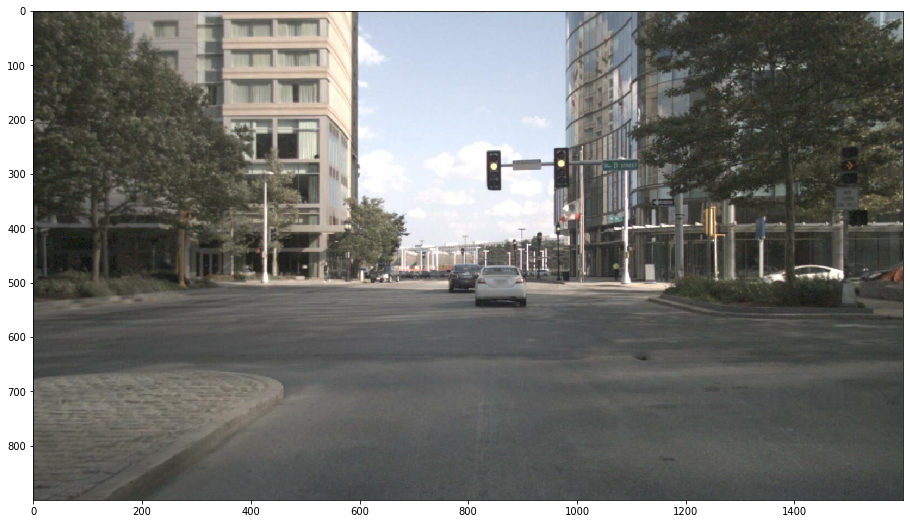

In [21]:
#Load image and display it
img = cv2.imread(t2c.commands[0].get_image_path())
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

turn left to pick up the pedestrian at the corner


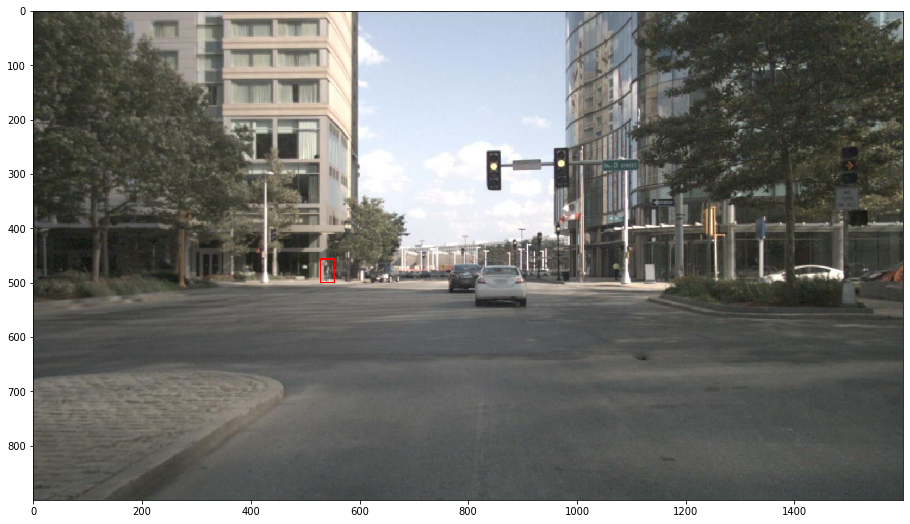

In [22]:
# Draw the bounding box if we have specified the correct version
if version == "train":
    (x,y,w,h)=t2c.commands[0].get_2d_bbox()
    cv2.rectangle(img, (x, y), (x+w, y+h), (255,0,0), 2)
    plt.imshow(img)
    print(t2c.commands[0].text)

Note: As the **Talk2Car** data loader is built on the nuScenes data loader, you can also use the functions provided it. For more information about the functions provided by the nuScenes data loader, click [here](https://www.nuscenes.org/tutorial)

# Simple model

The simple model we will use in this notebook, is a random selection model.
More specifically: We trained a SSD object detector on the Talk2Car training set and we use it to extract **64 regions** from the images in the training and test set. Then, for each command, we load the regions for the corresponding image and randomly select one of the 64 regions.

In [23]:
# Load the regions
regions = json.load(open("ssd_regions.json", "r"))

# regions is a dictionary of the format {frame_token: [[bbox1, class_prediction1],
#                                                     [bbox2, class_prediction2], ...,
#                                                     [bbox64, class_prediction64]]}
# The bounding box format is: x,y,w,h where x and y is the left top corner
# class_predictionX is an int that represents the class
regions["23a9d2cd27324db6958f65365d92be75"]

[[[377, 73, 400, 161], 1],
 [[399, 101, 425, 183], 1],
 [[423, 102, 447, 185], 1],
 [[504, 123, 528, 203], 1],
 [[524, 123, 552, 216], 1],
 [[451, 126, 480, 221], 1],
 [[473, 136, 496, 231], 1],
 [[1061, 240, 1098, 310], 1],
 [[46, 368, 195, 432], 16],
 [[1465, 394, 1525, 418], 16],
 [[10, 381, 177, 447], 16],
 [[956, 402, 1021, 429], 16],
 [[991, 405, 1049, 430], 16],
 [[1255, 403, 1316, 436], 16],
 [[1472, 395, 1553, 436], 16],
 [[1498, 393, 1577, 435], 16],
 [[1532, 389, 1589, 442], 16],
 [[858, 415, 922, 452], 22],
 [[865, 404, 955, 462], 22],
 [[958, 404, 1073, 458], 16],
 [[981, 412, 1052, 447], 16],
 [[1009, 401, 1126, 461], 16],
 [[1069, 410, 1154, 448], 16],
 [[1202, 403, 1317, 457], 16],
 [[1220, 410, 1307, 443], 16],
 [[1274, 411, 1351, 443], 16],
 [[1435, 394, 1571, 455], 16],
 [[1506, 392, 1598, 463], 16],
 [[509, 429, 570, 461], 16],
 [[874, 428, 903, 466], 1],
 [[907, 426, 929, 463], 1],
 [[1048, 416, 1196, 474], 16],
 [[1091, 424, 1184, 456], 16],
 [[494, 433, 524, 483]

In [24]:
# If you would like to convert the class_predictionX int to a string, we provide the following class.

class ClassMapping(object):
    N_CLASSES = 23
    CLASSES = ('animal','human.pedestrian.adult', 'human.pedestrian.child',
                  'human.pedestrian.construction_worker', 'human.pedestrian.personal_mobility',
                  'human.pedestrian.police_officer', 'human.pedestrian.stroller', 'human.pedestrian.wheelchair',
                  'movable_object.barrier', 'movable_object.debris', 'movable_object.pushable_pullable',
                  'movable_object.trafficcone', 'static_object.bicycle_rack', 'vehicle.bicycle',
                  'vehicle.bus.bendy', 'vehicle.bus.rigid', 'vehicle.car', 'vehicle.construction','vehicle.emergency.ambulance',
                  'vehicle.emergency.police', 'vehicle.motorcycle', 'vehicle.trailer', 'vehicle.truck')

    label_to_id = dict(map(reversed, enumerate(CLASSES)))
    id_to_label = dict(enumerate(CLASSES))

convertor = ClassMapping()
bbox_pred = regions["23a9d2cd27324db6958f65365d92be75"][0]
print(bbox_pred)

# Convert class_prediction to text
print(convertor.id_to_label[bbox_pred[1]])

[[377, 73, 400, 161], 1]
human.pedestrian.adult


In [27]:
# The 'Simple Model'
# loop over the loaded commands and select one region 
predictions = {}
for command in t2c.commands:
    # get regions for the image the command belongs to.
    bbox_for_image = regions[command.frame_token]
    
    # Randomly select one of the regions
    # Remember that a bounding box in the region is defined as [(x,y,w,h), cl]
    # As we're not interested in the class, we only select the first bounding box
    predictions[command.command_token] = random.choice(bbox_for_image)[0]

# Output the predictions

The output should be a dictionary of the format {command_tokenX: [x1,y1,w1,h1], command_token2: [x2,y2,w2,h2], ...  }

In [10]:
json.dump(predictions, open("predictions.json", "w"))